#Procesamiento de datos del Visound

Esta rutina procesa y visualiza los datos que se generan con el programa visound.
La app va subiendo los datos a un servidor. Este servidor corre en una virtual machine en la compu de casa sobre un ubuntu server en el que instale un json-server. 
Esta rutina descarga los datos del servidor en su ultima version y los procesa para hacer una visualizacion de la actividad de los usuarios en forma grafica (un timeline de la actividad)

In [1]:
%matplotlib inline
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
import datetime
import urllib.request
import os.path
import matplotlib.dates as mdates
import pytz

# Recoleccion de datos

Bajamos la ultima version del archivo de internet y nos fijamos de guardar la version anterior con una marca temporal

In [2]:
# Definimos cosas 
url='http://turintur.dynu.com/db' 
filenameTemp = 'temp.json'
filename = 'db.json'
timestamp = time.time()
st = datetime.datetime.fromtimestamp(timestamp).strftime('%Y-%m-%d %H:%M:%S')
filenameBackup = './backups/' + filename[:-5] + ' backup ' + st + '.json'

# Bajamos el archivo 
urllib.request.urlretrieve(url, filenameTemp)


# Renombramos el archivo viejo y dejamos el descargado con el nombre que corresponde si se descargo bien
if os.path.isfile(filenameTemp):
    if os.path.isfile(filename):
        os.rename(filename,filenameBackup)
    os.rename(filenameTemp,filename)

# Cargamos la info del archivo json en un objeto legible

with open(filename) as data_file:    
    db = json.load(data_file)



In [3]:
# Cargo la data de las sesiones en una tabla pandas
sessions = pd.concat((pd.DataFrame(x) for x in db['SessionEnviables']), ignore_index=True)
# Transformo la info de los logueos en formato unixtime a una fecha legible (en zona horaria GTM=0)
sessions['sessionDate'] = pd.to_datetime(sessions['id'], unit='ms')
# Cargo de los niveles
levels = pd.concat((pd.DataFrame(x) for x in db['LevelEnviables']), ignore_index=True)
# Carga las fechas en formato legible para todo lo que corresponda
levels['fechaEnvio'] = pd.to_datetime(levels['idEnvio'], unit='ms')
levels['fechaLevelStart'] = pd.to_datetime(levels['timeStarts'], unit='ms')
levels['fechaLevelExit'] = pd.to_datetime(levels['timeExit'], unit='ms')
# Carga la info de los trials
trials = pd.concat((pd.DataFrame(x) for x in db['TrialEnviables']), ignore_index=True)
# Convierte a fecha legible todo lo que tiene sentido
trials['fechaEnvio'] = pd.to_datetime(trials['idEnvio'], unit='ms')
trials['fechaTrialExit'] = pd.to_datetime(trials['timeExitTrial'], unit='ms')
trials['fechaTrialStart'] = pd.to_datetime(trials['timeTrialStart'], unit='ms')
# Ahora creamos la tabla con toda la info de cada toque y sound para lo que hay que buscar y concatenar la info fragmentada en cada trial
touchs = pd.concat(pd.DataFrame(x) for x in list(trials['touchLog']) if x is not np.nan)
sounds = pd.concat(pd.DataFrame(x) for x in list(trials['soundLog']) if x is not np.nan)
# Crea una lista de usuario
usuarios = pd.DataFrame(pd.unique(list(sessions['userID'])),columns=['usuarios'])
usuarios = usuarios.reset_index()
usuarios.rename(columns={'index': 'Alias'}, inplace=True)



In [36]:
sounds.columns

Index(['categorias', 'fromStimuli', 'levelInstance', 'numberOfLoop',
       'numberOfSoundInTrial', 'sessionInstance', 'soundId', 'soundInstance',
       'soundSecuenceInTrial', 'stopByEnd', 'stopByExit', 'stopTime',
       'tipoDeTrial', 'trialId', 'trialInstance'],
      dtype='object')

# Con los datos ya cargados graficamos los resultados

La idea de esta seccion es hacer un analisis visual de los datos. Para eso vamos a armar un timeline donde vamos a mostrar con dibujos (lines, rectangulos, etc) lo que va pasando en el juego en funcion de diferentes criterios. Para un usuario cuando jugo, en usa sesion que paso, etc.

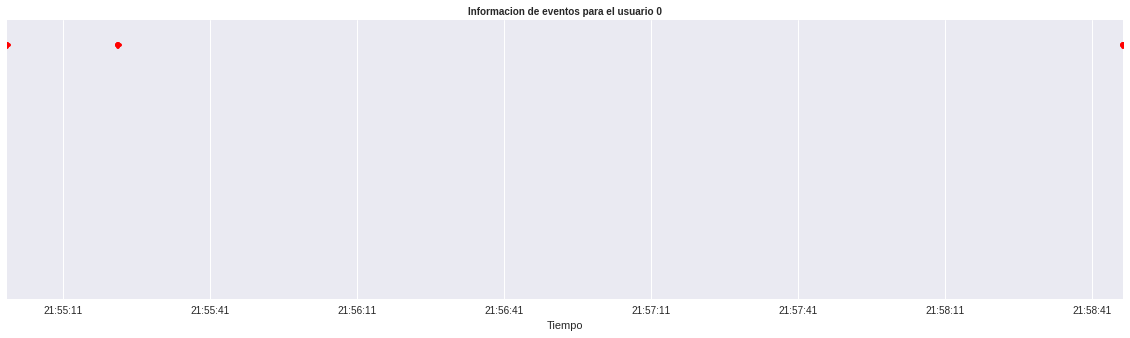

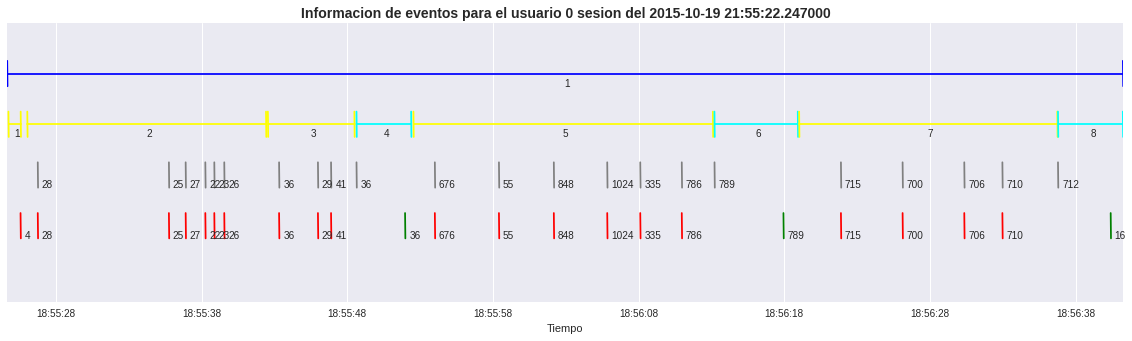

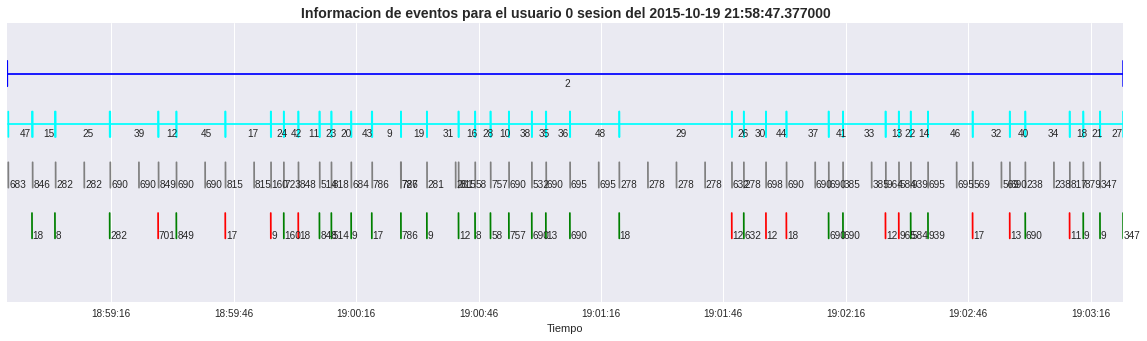

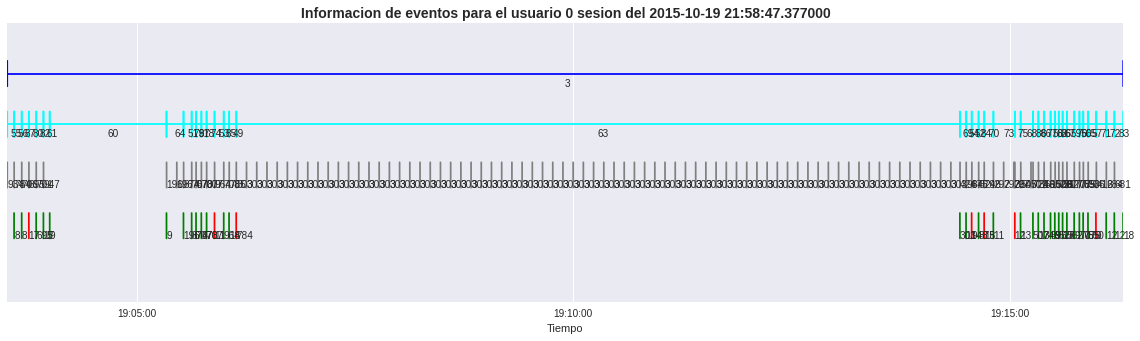

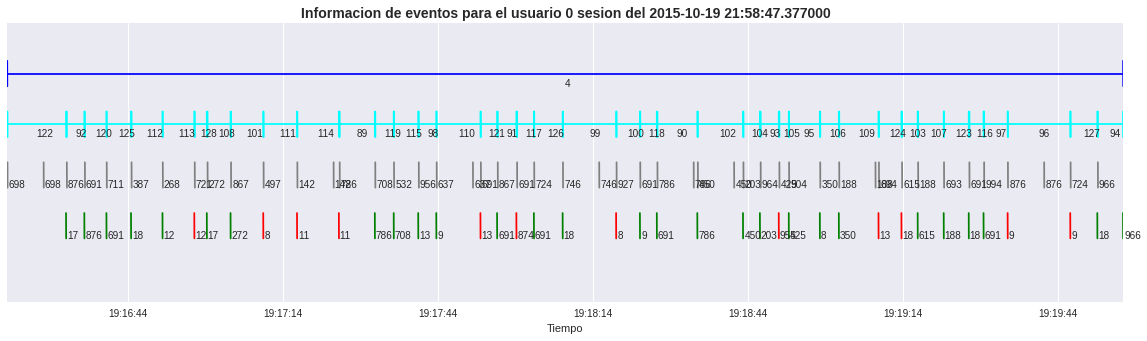

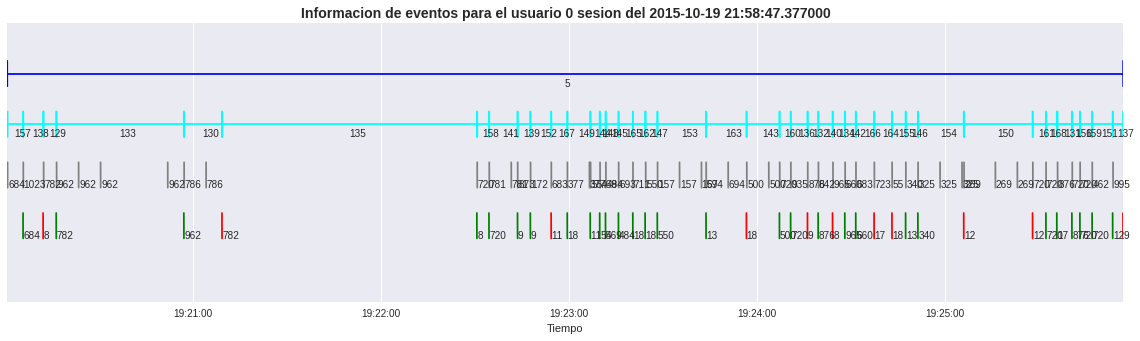

In [38]:
juntar = False # Si es true, junta todos los levels de una misma sesion, sino separa por level

for index, usuario in usuarios.iterrows():
    # Genera el plot
    fig = plt.figure(figsize=(20,5))
    
    ax = fig.add_subplot(111)
    ax.set_title('Informacion de eventos para el usuario {}'.format(usuario['Alias']), fontsize=10, fontweight='bold')
    ax.set_xlabel('Tiempo')
    ax.set_ylabel('')
    ax.get_yaxis().set_ticks([])
    ax.set_ylim([0,11])
    

    
    # Procesa la info de las sesiones
    sesionesUsuario = sessions[sessions['userID']==usuario['usuarios']]
    fechas = sesionesUsuario['sessionDate']
    altura = np.ones(fechas.size)*10
    ax.plot(fechas,altura,'ro')
    
    # ahora para este usuario va a hacer un grafico por sesion
    for index, session in sesionesUsuario.iterrows():

        #Carga los levels de la sesion
        levelsSesion = levels[levels['sessionId']==session['id']]
        
        if juntar: #Crea un grafico nuevo si esta configurado asi
            if levelsSesion.size > 0:
                # Genera el plot si se va a usar
                fig = plt.figure(figsize=(20,5))
                ax = fig.add_subplot(111)
                ax.set_title('Informacion de eventos para el usuario '+str(usuario['Alias'])+' sesion del '+str(session['sessionDate']), fontsize=14, fontweight='bold')
                ax.set_xlabel('Tiempo')
                ax.set_ylabel('')
                ax.get_yaxis().set_ticks([])
                ax.set_ylim([0,11])

        # Procesa la info de los levels
        for index, level in levelsSesion.iterrows():
           
            if not juntar: #Crea un grafico nuevo si esta configurado asi
                # Genera el plot si se va a usar
                fig = plt.figure(figsize=(20,5))
                ax = fig.add_subplot(111)
                ax.set_title('Informacion de eventos para el usuario '+str(usuario['Alias'])+' sesion del '+str(session['sessionDate']), fontsize=14, fontweight='bold')
                ax.set_xlabel('Tiempo')
                ax.set_ylabel('')
                ax.get_yaxis().set_ticks([])
                ax.set_ylim([0,11])
        
            # Configura el color segun este completado o no el nivel
            if level['levelCompleted'] == True:
                color = 'blue'
            else:
                color = 'red'
            # Grafica el segmento principal
            x = [datetime.datetime.fromtimestamp (level['timeStarts']/1000),datetime.datetime.fromtimestamp (level['timeExit']/1000)]
            y = [9,9]
            ax.plot(x,y,color=color)
            # Grafica dos bordes para remarcar los inicios y los finales
            ax.plot([datetime.datetime.fromtimestamp(level['timeStarts']/1000-0.01),datetime.datetime.fromtimestamp(level['timeStarts']/1000+0.01)],[y[0]+0.5,y[0]-0.5],color=color)
            ax.plot([datetime.datetime.fromtimestamp(level['timeExit']/1000-0.01),datetime.datetime.fromtimestamp(level['timeExit']/1000+0.01)],[y[0]+0.5,y[0]-0.5],color=color)
            # Agrega el id del nivel
            xCenter = datetime.datetime.fromtimestamp ((level['timeStarts']/1000+level['timeExit']/1000)/2)
            ax.text(xCenter, 8.5, level['levelId'])

            # Procesa la info de los trials del level en cuestion
            trialsSesion = trials[trials['levelInstance']==level['levelInstance']]
            for index, trial in trialsSesion.iterrows():
                # Configura el color segun el tipo de trial
                if trial['tipoDeTrial'] == 'ENTRENAMIENTO':
                    color = 'yellow'
                else:
                    color = 'cyan'
                # Grafica el segmento principal
                x = [datetime.datetime.fromtimestamp (trial['timeTrialStart']/1000),datetime.datetime.fromtimestamp (trial['timeExitTrial']/1000)]
                y = [7,7]
                ax.plot(x,y,color=color)
                # Grafica dos bordes para remarcar los inicios y los finales
                ax.plot([datetime.datetime.fromtimestamp(trial['timeTrialStart']/1000-0.01),datetime.datetime.fromtimestamp(trial['timeTrialStart']/1000+0.01)],[y[0]+0.5,y[0]-0.5],color=color)
                ax.plot([datetime.datetime.fromtimestamp(trial['timeExitTrial']/1000-0.01),datetime.datetime.fromtimestamp(trial['timeExitTrial']/1000+0.01)],[y[0]+0.5,y[0]-0.5],color=color)
                # Agrega el id del trial
                xCenter = datetime.datetime.fromtimestamp ((trial['timeTrialStart']/1000+trial['timeExitTrial']/1000)/2)
                ax.text(xCenter, 6.5, trial['trialId'])
                
                # Procesa los toques en cada trial
                touchsTrial = touchs[touchs['trialInstance']==trial['trialInstance']]
                for index, touch in touchsTrial.iterrows():

                    # Configura el color segun sea un acierto o no
                    if touch['isTrue'] == True: # Ojo que aca un Nan es un false!
                        color = 'green'
                    else:
                        color = 'red'

                    y = [3,3]
                    # Grafica el segmento cuasivertical
                    ax.plot([datetime.datetime.fromtimestamp(touch['touchInstance']/1000-0.01),datetime.datetime.fromtimestamp(touch['touchInstance']/1000+0.01)],[y[0]+0.5,y[0]-0.5],color=color)
                    # Agrega el id del elemento tocado
                    xCenter = datetime.datetime.fromtimestamp (touch['touchInstance']/1000+0.3)
                    ax.text(xCenter, 2.5, touch['idResourceTouched']['id'])
                
                # Procesa los sounds en cada trial
                soundsTrial = sounds[sounds['trialInstance']==trial['trialInstance']]
                for index, sound in soundsTrial.iterrows():

                    # Configura el color
                    color = 'gray'
                    y = [5,5]
                    # Grafica el segmento cuasivertical
                    ax.plot([datetime.datetime.fromtimestamp(sound['soundInstance']/1000-0.01),datetime.datetime.fromtimestamp(sound['soundInstance']/1000+0.01)],[y[0]+0.5,y[0]-0.5],color=color)
                    # Agrega el id del elemento tocado
                    xCenter = datetime.datetime.fromtimestamp (sound['soundInstance']/1000+0.3)
                    ax.text(xCenter, 4.5, sound['soundId']['id'])
                

# Cosas de estadistica

En esta seccion se va a hacer un procesamiento estidistico de los datos para evaluar los resultados en funcion de diferentes parametros.


In [70]:
for index, usuario in usuarios.iterrows():
    analizarUsuario(usuario)

Se analizara las estadisticas del usuario 0:
Cantidad de veces que se logueo el usuario: 3
Fechas:
2015-10-19 18:54:59.523999
2015-10-19 18:55:22.246999
2015-10-19 18:58:47.377000

Se analizara la sesion del 2015-10-19 18:54:59.523999
Numero de niveles jugados en esta sesion: 0
Se analizara la sesion del 2015-10-19 18:55:22.246999
Numero de niveles jugados en esta sesion: 1
Se analizara la sesion del 2015-10-19 18:58:47.377000
Numero de niveles jugados en esta sesion: 4


In [63]:
def fechaLocal (millisec):
    return datetime.datetime.fromtimestamp(millisec/1000)
    

In [62]:
def analizarUsuario (usuario):
    
    print ('Se analizara las estadisticas del usuario '+ str(usuario['Alias'])+':')
    sesionesUsuario = sessions[sessions['userID']==usuario['usuarios']]
    
    print ('Cantidad de veces que se logueo el usuario: '+str(len(sesionesUsuario.index)))
    print ('Fechas:')
    
    for fecha in sesionesUsuario['id']:
        print (str(fechaLocal(fecha)))
    
    print ('')
    
    for index, session in sesionesUsuario.iterrows():
        analizarSesion(session)

In [69]:
def analizarSesion (sesion):
    print ('Se analizara la sesion del '+ str(fechaLocal(sesion['id'])))
    levelsSesion = levels[levels['sessionId']==sesion['id']]

    print ('Numero de niveles jugados en esta sesion: '+str(len(levelsSesion.index)))
